# Solving Collision

Collision are currently only avoided in 2D. 

### How does it work ? 
A force field is defined for each cell. The purpose of this force field is to prevent a vertex from entering a cell. We will use the `repulsion` effector to have collision avoidance in 2D.  
For each vertex, full force field is made by adding all the cell force fields, except those of the cells belonging to the vertex. 

![Solving Collision](illus/collision.png)

In [1]:
import os

import numpy as np
import pandas as pd

from tyssue import PlanarGeometry
from tyssue.dynamics import effectors, model_factory
from tyssue.solvers import QSSolver
from tyssue.behaviors.event_manager import EventManager
from tyssue.generation.shapes import generate_lateral_tissue
from tyssue.core.history import History
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt

In [2]:
from tyssue.dynamics.effectors import AbstractEffector
from tyssue.dynamics import units
from tyssue.utils import to_nd

class LateralGeometry(PlanarGeometry):

    @classmethod
    def update_all(cls, eptm):
        cls.update_support_distance(eptm)
        cls.update_wall_distance(eptm)
        PlanarGeometry().update_repulsion(eptm)
        PlanarGeometry().update_all(eptm)

    @staticmethod
    def center(eptm, axis=None):
        if axis is None:
            PlanarGeometry.center(eptm)
        else:
            eptm.vert_df[axis] = (
                    eptm.vert_df[axis].values
                    - eptm.vert_df[axis].mean(axis=0)
            )

    @staticmethod
    def update_support_distance(eptm):
        # a = 8
        # b = 2
        # y = b / a * np.sqrt(a ** 2 - eptm.vert_df["x"] ** 2)
        eptm.vert_df["delta_rho"] = (-eptm.vert_df["y"]).clip(lower=0)
    
        eptm.vert_df["delta_ecm"] = (eptm.vert_df["y"]).clip(lower=0)
        apical_vert = eptm.vert_df[eptm.vert_df['segment'] == 'apical'].index
        eptm.vert_df.loc[apical_vert, "delta_ecm"] = 0


    @staticmethod
    def update_wall_distance(eptm):
        if ("wall_left" in eptm.settings) and ("wall_right" in eptm.settings):
            wall_left = eptm.settings["wall_left"]
            wall_right = eptm.settings["wall_right"]

            eptm.vert_df['wall_distance'] = (wall_left - eptm.vert_df["x"]).clip(lower=0)
            eptm.vert_df['wall_distance'] += (eptm.vert_df["x"] - wall_right).clip(lower=0)

            
class SupportElasticity(AbstractEffector):
    """
    Barrier use to maintain the tissue integrity, for 2.5D geometry
    ..math: \frac{1}{2} K_barrier \delta \rho^2
    """

    dimensions = units.line_elasticity
    magnitude = "support_elasticity"
    label = "Support elasticity"
    element = "vert"
    specs = {
        "vert": {"support_elasticity": 1.0, "is_active": 1, "delta_rho": 0.0}
    }  # distance to a barrier membrane

    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval("delta_rho**2 * support_elasticity/2")

    @staticmethod
    def gradient(eptm):
        grad = eptm.vert_df[eptm.coords] * to_nd(
            eptm.vert_df.eval("support_elasticity * delta_rho"), len(eptm.coords)
        )
        grad.columns = ["g" + c for c in eptm.coords]
        grad["gx"] = 0
        return grad, None


class WallElasticity(AbstractEffector):
    dimensions = units.line_elasticity
    magnitude = "support_elasticity"
    label = "Support elasticity"
    element = "vert"
    specs = {
        "vert": {"wall_elasticity": 1.0, "is_active": 1, "wall_distance": 0.0}
    }  # distance to a barrier membrane

    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval("wall_distance**2 * wall_elasticity/2 * is_active")

    @staticmethod
    def gradient(eptm):
        grad = eptm.vert_df[eptm.coords] * to_nd(
            eptm.vert_df.eval("wall_distance * wall_elasticity"), len(eptm.coords)
        )
        grad.columns = ["g" + c for c in eptm.coords]
        grad["gy"] = 0
        return grad, None
    


In [3]:
from tyssue.utils.decorators import face_lookup
from tyssue.geometry.sheet_geometry import SheetGeometry
from tyssue.behaviors.sheet.actions import increase
from tyssue.topology.sheet_topology import cell_division

def find_opp(sheet, new_edge_id):
    for e in new_edge_id:
        srce_e, trgt_e = sheet.edge_df.loc[e][['srce', 'trgt']]
        for ee in new_edge_id:
            srce_ee, trgt_ee = sheet.edge_df.loc[ee][['srce', 'trgt']]
            if (srce_e == trgt_ee) and (trgt_e == srce_ee):
                return [e, ee]


default_division_spec = {
        "face_id": -1,
        "face": -1,
        "growth_rate": 0.1,
        "critical_area": 2.0,
        "geom": SheetGeometry,
    }

@face_lookup
def division(sheet, manager, **kwargs):
    """Cell division happens through cell growth up to a critical volume,
    followed by actual division of the face.

    Parameters
    ----------
    sheet : a `Sheet` object
    manager : an `EventManager` instance
    face_id : int,
      index of the mother face
    growth_rate : float, default 0.1
      rate of increase of the prefered volume
    critical_area : float, default 2.
      volume at which the cells stops to grow and devides

    """
    division_spec = default_division_spec
    division_spec.update(**kwargs)

    face = division_spec["face"]

    if sheet.face_df.loc[face, "area"] < division_spec["critical_area"]:
        increase(
            sheet, "face", face, division_spec["growth_rate"], "prefered_area", True
        )
        manager.append(division, **division_spec)
    else:
        AB_edges = sheet.edge_df[(sheet.edge_df['face'] == face) & (
                (sheet.edge_df["segment"] == "apical") | (sheet.edge_df["segment"] == "basal"))].index

        angle = np.arctan2(sheet.edge_df.loc[[AB_edges[0]]].eval('(sx+tx)/2') - sheet.face_df.loc[face, 'x'],
                           sheet.edge_df.loc[[AB_edges[0]]].eval('(sy+ty)/2') - sheet.face_df.loc[face, 'y'],).to_numpy()[0]

        if angle < 0:
            angle = np.pi + angle


        daughter = cell_division(sheet, face, division_spec["geom"], angle=angle)

        sheet.face_df.loc[daughter, "id"] = sheet.face_df.id.max() + 1
        # sheet.face_df.loc[daughter, "unique_id"] = sheet.specs['face']['unique_id_max'] + 1
        # sheet.specs['face']['unique_id_max'] += 1
        #
        # sheet.lineage.add_node(str(sheet.face_df.loc[daughter]['unique_id']),
        #                        color='grey')
        # sheet.lineage.add_edge(str(sheet.face_df.loc[face]['unique_id']),
        #                        str(sheet.face_df.loc[daughter]['unique_id']))

        sheet.face_df.loc[daughter, 'prefered_area'] = sheet.specs['face']['prefered_area']
        sheet.face_df.loc[face, 'prefered_area'] = sheet.specs['face']['prefered_area']

        new_edge_id = sheet.edge_df[(sheet.edge_df['face'].isin([face, daughter]))].index
        lat_edge = find_opp(sheet, new_edge_id)
        sheet.edge_df.loc[lat_edge, 'segment'] = "lateral"
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df["face"] == daughter].index, 'line_tension'] = 1

## Define model

In [4]:
model = model_factory([
    effectors.FaceAreaElasticity,
    effectors.PerimeterElasticity,
    effectors.Repulsion,
    SupportElasticity,
    WallElasticity,
])

## Create 2D lateral tissue

In [5]:
sheet = generate_lateral_tissue(20,16, 2)
sheet.sanitize(trim_borders = False, order_edges=True)
LateralGeometry.center(sheet, "x")
LateralGeometry.update_all(sheet)

# update parameter according to model requested
specs = model.specs
specs['settings']['geometry'] = "flat"

specs['face']['prefered_area'] = 2.
specs['face']['prefered_perimeter'] = 6
specs['face']['area_elasticity'] = 1
specs['face']['perimeter_elasticity'] = 1

specs['vert']['ecm_elasticity'] = 10
specs['vert']['support_elasticity'] = 10
specs['settings']['wall_left'] = -8
specs['settings']['wall_right'] = 8 
specs['vert']['wall_elasticity'] = 100
specs['vert']["force_repulsion"] = 100

sheet.face_df["id"] = sheet.face_df.index
sheet.vert_df["repulse_u"] = 0
sheet.vert_df["repulse_v"] = 0

sheet.update_specs(specs, reset=True)

LateralGeometry.update_all(sheet)

border_vert = sheet.vert_df.loc[[np.argmin(sheet.vert_df['x']), np.argmax(sheet.vert_df['x'])]].index.to_numpy()

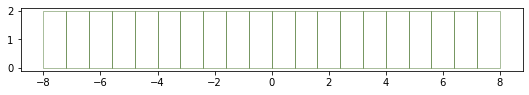

In [6]:
fig, ax = sheet_view(sheet)
fig.set_size_inches((10,10))

In [7]:
solver_qs = QSSolver(with_t1=False, with_t3=False, with_collisions=False)
res = solver_qs.find_energy_min(sheet, LateralGeometry, model, periodic=False, options={"gtol": 1e-8})
sheet.vert_df[["x", "y"]] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
LateralGeometry.update_all(sheet)

## Tissue development with cell division

In [8]:
manager = EventManager()
history = History(sheet)


for j in range(20):
    print(j)
    
    faces = np.random.randint(8, high=13, size=3)
    for f in faces:
        manager.append(division, **{"face_id":list(sheet.get_neighbors(f))[0],
                        "growth_rate":1.04,
                        "critical_area":3,
                       "geom":LateralGeometry})


    for i in range(10):
        print('i :'+str(i))

        manager.execute(sheet)
        res = solver_qs.find_energy_min(sheet, LateralGeometry, model, periodic=False, options={"gtol": 1e-8})

        sheet.vert_df[["x", "y"]] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        LateralGeometry.update_all(sheet)
        manager.update()
        history.record()


0
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
1
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
2
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
3
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
4
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
5
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
6
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
7
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
8
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
9
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
10
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
11
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
12
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
13
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
14
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
15
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
16
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
17
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
18
i :0
i :1
i :2
i :3
i :4
i :5
i :6
i :7
i :8
i :9
19


In [9]:
from tyssue.draw.ipv_draw import browse_history
specs = {
    'face': {
        'visible': False,
        "color": "blue",
        "color_range":[0, 2],
    },
    'edge': {
        'visible': True,
        'color': 'black',
        'colormap': 'bwr',
        'color_range': [0, 2.5],
        'width': 4,
        'alpha': 1,
    },
    'vert': {
        'visible': False,
    }

}
browse_history(history, coords=["x", "y"], **specs)

interactive(children=(IntSlider(value=0, description='i', max=200), Output()), _dom_classes=('widget-interact'…